#####   1. Getting and preprocessing input data

In [1]:
# Set working directory and path to shapefile of study area

working_dir = 'volta'  #provide working folder directory
study_area = 'bakaano/test/volta.shp'  #provide path to shapefile of study_area
start_date = '1981-01-01'  # provide start date in format e.g. '2016-12-31'
end_date = '1990-12-31'  #provide end date in format e.g. '2016-12-31'

     - Tree cover data already exists in volta/vcf/mean_tree_cover.tif; skipping download.
     - Tree cover data already exists in volta/vcf/mean_tree_cover.tif; skipping preprocessing.


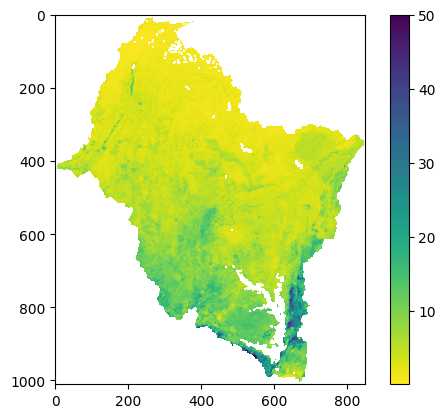

In [2]:
from bakaano.tree_cover import TreeCover
vf = TreeCover(working_dir, study_area)
vf.download_tree_cover()
vf.preprocess_tree_cover()
vf.plot_tree_cover()

     - NDVI data already exists in volta/ndvi/daily_ndvi_climatology.pkl; skipping download.
     - NDVI data already exists in volta/ndvi/daily_ndvi_climatology.pkl; skipping preprocessing.


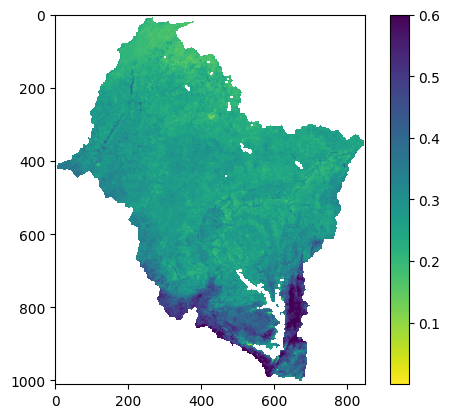

In [3]:
from bakaano.ndvi import NDVI
nd = NDVI(working_dir, study_area)
nd.download_ndvi()
nd.preprocess_ndvi()
nd.plot_ndvi()

     - DEM data already exists in volta/elevation; skipping download.


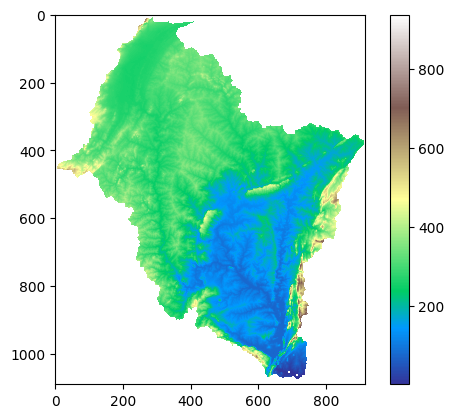

In [4]:
# Get elevation data

from bakaano.dem import DEM
dd = DEM(working_dir, study_area, local_data=False, local_data_path=None)
dd.get_dem_data()
dd.plot_dem()

     - Soil data already exists in volta/soil; skipping download.


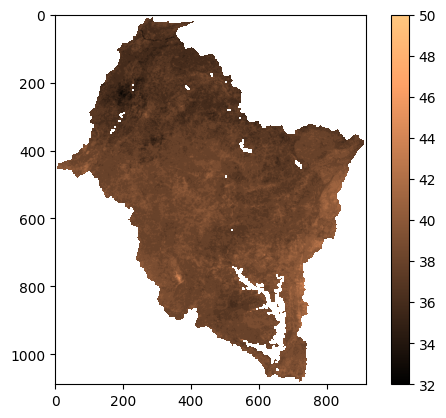

In [5]:
# Get soil data

from bakaano.soil import Soil
sgd = Soil(working_dir, study_area)
sgd.get_soil_data()
sgd.plot_soil(vmax=50)

In [ ]:
# Get meteo data

from bakaano.meteo import Meteo
cd = Meteo(working_dir, study_area, start_date=start_date, end_date=end_date, local_data=False, data_source='CHELSA', local_prep_path=None, local_tasmax_path=None, 
           local_tasmin_path=None, local_tmean_path=None)
prep, tasmax, tasmin, tmean = cd.get_meteo_data()

#####   2. Computing runoff and routing to river network

In [ ]:
climate_data_source = 'ERA5'

from bakaano.veget import VegET
vg = VegET(working_dir, study_area, start_date, end_date, climate_data_source=climate_data_source)
vg.compute_veget_runoff_route_flow(prep, tasmax, tasmin, tmean)

#####   3. Training Bakaano-Hydro model 

In [ ]:
#TRAINING THE NEURAL NETWORK MODEL
# Initialize  instance of Bakaano-Hydro model

train_start_date = ''
train_end_date = ''
grdc_netcdf = 'volta/GRDC-Daily-africa-south-america.nc'   #provide path to netcdf format of observed streamflow obtained from GRDC
climate_data_source = 'ERA5'

from bakaano.runner import BakaanoHydro
bk = BakaanoHydro(  
    working_dir,
    study_area,
    train_start_date,
    train_end_date,
    climate_data_source=climate_data_source
)

bk.train_streamflow_model(grdc_netcdf=grdc_netcdf,  loss_fn='mean_squared_logarithmic_error', 
                          num_input_branch=3, lookback=365, batch_size=256, num_epochs=100)

#####   4. Evaluating Bakaano-Hydro model performance

In [ ]:
#EVALUATING THE NEURAL NETWORK MODEL
model_path = f'{working_dir}/models/deepstrmm_model_tcn365.keras'
grdc_netcdf = ''   #provide path to netcdf format of observed streamflow obtained from GRDC
val_start_date = ''
val_end_date = ''

from bakaano.runner import BakaanoHydro
bk = BakaanoHydro(
    working_dir,
    study_area,
    val_start_date,
    val_end_date
)

bk.evaluate_streamflow_model(model_path='', grdc_netcdf=grdc_netcdf, prep_nc=prep, tasmax_nc=tasmax, tasmin_nc=tasmin, tmean_nc=tmean,
                             loss_fn='mean_squared_logarithmic_error', num_input_branch=3, lookback=365, batch_size=256)

#####   5. Simulating streamflow series with Bakaano-Hydro

In [ ]:
model_path = f'{working_dir}/models/deepstrmm_model_tcn365.keras'
lat = ''
lon = ''

from bakaano.runner import BakaanoHydro
bk = BakaanoHydro(
    working_dir,
    study_area,
    val_start_date,
    val_end_date
)

latlist = []
lonlist =[]
bk.simulate_streamflow_batch(model_path='', latlist=latlist, lonlist=lonlist, grdc_netcdf=grdc_netcdf, prep_nc=prep, tasmax_nc=tasmax, tasmin_nc=tasmin, tmean_nc=tmean,
                             loss_fn='mean_squared_logarithmic_error', num_input_branch=3, lookback=365)